# BGS Signal-to-Noise Ratio and Redshift Efficiency

The goal of this notebook is to assess the signal-to-noise ratio and redshift efficiency of BGS targets observed in "nominal" observing conditions (which are defined [here](https://github.com/desihub/desisurvey/blob/master/py/desisurvey/data/config.yaml#L102) and discussed [here](https://github.com/desihub/desisurvey/issues/77), among other places).  Specifically, the nominal BGS observing conditions we adopt (note the 5-minute exposure time is with the moon down!) are:

```python
{'AIRMASS': 1.0,
 'EXPTIME': 300,
 'SEEING': 1.1,
 'MOONALT': -60,
 'MOONFRAC': 0.0,
 'MOONSEP': 180}
```

During the survey itself, observations with the moon up (i.e., during bright time) will be obtained with longer exposure times according to the bright-time exposure-time model (see [here](https://github.com/desihub/surveysim/tree/master/doc/nb)).

Because we fix the observing conditions, we only consider how redshift efficiency depends on galaxy properties (apparent magnitude, redshift, 4000-A break, etc.).  However, note that the code is structured such that we *could* (now or in the future) explore variations in seeing, exposure time, and lunar parameters.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` and `desitarget.mock.build.targets_truth`.

Finally, note that the various python Classes instantiated here (documented in `desitarget.mock.mockmaker`) are easily extensible to other mock catalogs and galaxy/QSO/stellar physics.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits

In [3]:
from desispec.io.util import write_bintable
from desiutil.log import get_logger, DEBUG
log = get_logger()
from desitarget.cuts import isBGS_bright, isBGS_faint
## Following not yet available in the master branch
from desitarget.mock.mockmaker import BGSMaker
from desitarget.mock.mockmaker import SKYMaker

In [5]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Establish the I/O path, random seed, and path to the dust maps and desired healpixel.

In [7]:
simdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs', 'kremin', 'flat_priors')

if not os.path.exists(simdir):
    os.makedirs(simdir)

In [8]:
seed = 626

### All or none of the output files can be overwritten using these keywords.

In [33]:
overwrite_spectra = False
overwrite_templates = False
overwrite_redshifts = False
overwrite_results = False

#### Initialize random state

In [10]:
rand = np.random.RandomState(seed)

## Set up the simulation parameters.

Here we use the mock to capture the correct distribution of apparent magnitudes, galaxy properties, and redshifts.

Note that if `use_mock=False` then *rmagmin*, *rmagmax*, *zmin*, and *zmax* are required. For example, here's another possible simulation of 1000 spectra in which the magnitude (r=19.5) and redshift (z=0.2) are held fixed while moonfrac and moonsep are varied (as well as intrinsic galaxy properties):

```python
sim2 = dict(suffix='sim02',
            use_mock=False,
            nsim=10,
            nspec=100,
            seed=22,
            zmin=0.2, zmax=0.2,
            rmagmin=19.5, rmagmax=19.5,
            moonfracmin=0.0, moonfracmax=1.0,
            moonsepmin=0.0, moonsepmax=120.0,
           )
```

In [11]:
from desistudy import get_predefined_sim_dict, get_predefined_obs_dict

all_sims = []
all_obsconds = []
for simname in ['sim01','sim02','sim03','sim04']:
    all_sims.append(get_predefined_sim_dict(simname))
    all_obsconds.append(get_predefined_obs_dict(simname))

print(all_obsconds)

sims = np.atleast_1d(all_sims)
conditions = np.atleast_1d(all_obsconds)

[{'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONALT': -60, 'MOONSEP': 180, 'EXPTIME': 300, 'MOONFRAC': 0.0}, {'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONALT': 30, 'MOONSEP': 120, 'EXPTIME': 480, 'MOONFRAC': 0.8}, {'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONALT': 30, 'MOONSEP': 120, 'exptimemin': 300, 'exptimemax': 720, 'MOONFRAC': 0.8}, {'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONALT': 30, 'MOONSEP': 120, 'EXPTIME': 600, 'moonfracmin': 0.6, 'moonfracmax': 0.98}]


### Generate Spectra

In [19]:
from desistudy import bgs_sim_spectra

for sim,cond in zip(sims,conditions):
    log.info("Now performing sim {}".format(sim['suffix']))
    bgs_sim_spectra(sim, cond, simdir, verbose=False, overwrite=overwrite_spectra)

INFO:<ipython-input-19-dbddd738d760>:7:<module>: Now performing sim sim01
INFO:io.py:1013:read_basis_templates: Reading /global/project/projectdirs/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.
INFO:io.py:1025:read_basis_templates: Reading /global/project/projectdirs/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


KeyboardInterrupt: 

## Fit the redshifts.

This step took ~1.8 seconds per spectrum, ~3 minutes per 100 spectra, or ~30 minutes for all 1000 spectra with my 4-core laptop.

In [22]:
from desistudy import bgs_redshifts

for sim in sims:
    bgs_redshifts(sim, simdir=simdir, overwrite=overwrite_redshifts)

File /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-000-zbest.fits exists...skipping.
File /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-001-zbest.fits exists...skipping.
File /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim02/bgs-sim02-000-zbest.fits exists...skipping.
File /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim02/bgs-sim02-001-zbest.fits exists...skipping.
File /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim03/bgs-sim03-000-zbest.fits exists...skipping.
Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 1000 targets: 22.1 seconds
DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.5000-3.9956 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.

## Gather the results.

In [25]:
from desistudy import bgs_gather_results

for sim in sims:
    bgs_gather_results(sim, simdir=simdir, overwrite=overwrite_results)

INFO:desistudy.py:188:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-000-true.fits
INFO:desistudy.py:202:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-000-zbest.fits
INFO:desistudy.py:214:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-000.fits


INFO:desistudy.py:188:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-001-true.fits
INFO:desistudy.py:202:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-001-zbest.fits
INFO:desistudy.py:214:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-001.fits
INFO:desistudy.py:225:bgs_gather_results: Writing /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim01/bgs-sim01-results.fits
INFO:desistudy.py:188:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim02/bgs-sim02-000-true.fits
INFO:desistudy.py:202:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim02/bgs-sim02-000-zbest.fits
INFO:desistudy.py:214:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_prior

INFO:desistudy.py:214:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim04/bgs-sim04-004.fits
INFO:desistudy.py:188:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim04/bgs-sim04-005-true.fits
INFO:desistudy.py:202:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim04/bgs-sim04-005-zbest.fits
INFO:desistudy.py:214:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim04/bgs-sim04-005.fits
INFO:desistudy.py:188:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim04/bgs-sim04-006-true.fits
INFO:desistudy.py:202:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/sim04/bgs-sim04-006-zbest.fits
INFO:desistudy.py:214:bgs_gather_results: Reading /global/project/projectdirs/desi/spectro/sim/bgs/kremin/flat_priors/si

## Analyze the outputs.

We only have one simulation so the code below is hard-coded to sim1, although it would be trivial to generalize.

In [17]:
os.listdir(os.path.join(simdir,sims[2]['suffix']))

['bgs-sim03-002-true.fits',
 'bgs-sim03-001.fits',
 'bgs-sim03-simdata.fits',
 'bgs-sim03-008-zbest.fits',
 'bgs-sim03-003.fits',
 'bgs-sim03-results.fits',
 'bgs-sim03-004-true.fits',
 'bgs-sim03-008.fits',
 'bgs-sim03-000-true.fits',
 'bgs-sim03-007.fits',
 'bgs-sim03-006-zbest.fits',
 'bgs-sim03-005.fits',
 'bgs-sim03-005-true.fits',
 'bgs-sim03-003-true.fits',
 'bgs-sim03-009-zbest.fits',
 'bgs-sim03-003-zbest.fits',
 'bgs-sim03-001-true.fits',
 'bgs-sim03-005-zbest.fits',
 'bgs-sim03-008-true.fits',
 'bgs-sim03-006.fits',
 'bgs-sim03-007-true.fits',
 'bgs-sim03-004-zbest.fits',
 'bgs-sim03-000.fits',
 'bgs-sim03-002.fits',
 'bgs-sim03-001-zbest.fits',
 'bgs-sim03-000-zbest.fits',
 'bgs-sim03-006-true.fits',
 'bgs-sim03-009.fits',
 'bgs-sim03-007-zbest.fits',
 'bgs-sim03-004.fits',
 'bgs-sim03-009-true.fits',
 'bgs-sim03-002-zbest.fits']

In [27]:
from desistudy_qa import qa_zmag, qa_efficiency, qa_zwarn4, qa_radec

Sim: sim01 with nspec: 4000 and nsim: 2
ObsConds ExpTime: 300, MoonFrac: 0.0, MoonAlt: -60, MoonSep: 180


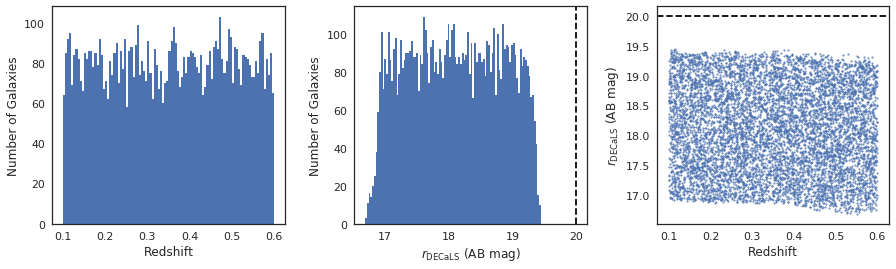

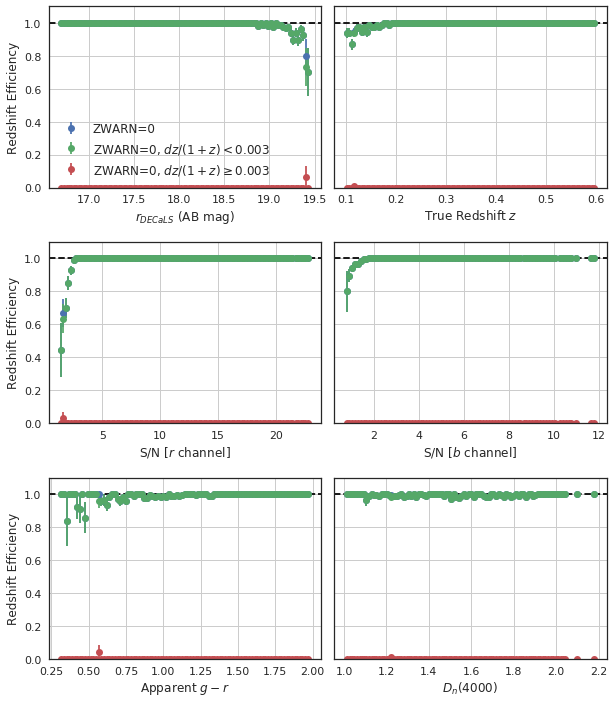

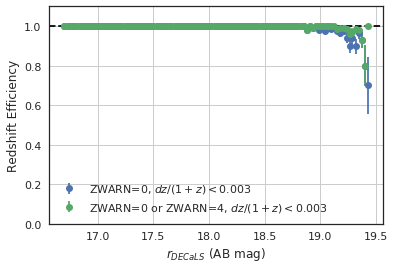

In [28]:
ind = 0
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)

Sim: sim02 with nspec: 4000 and nsim: 2
ObsConds ExpTime: 480, MoonFrac: 0.8, MoonAlt: 30, MoonSep: 120


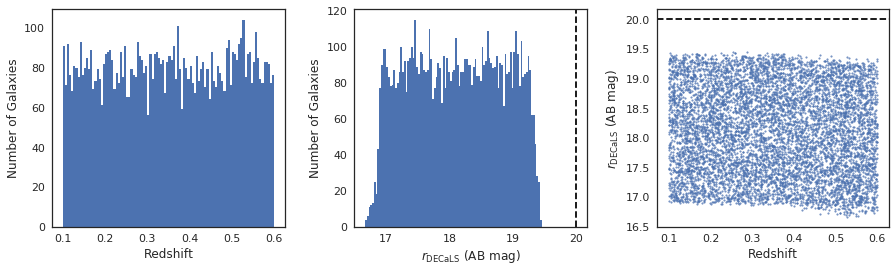

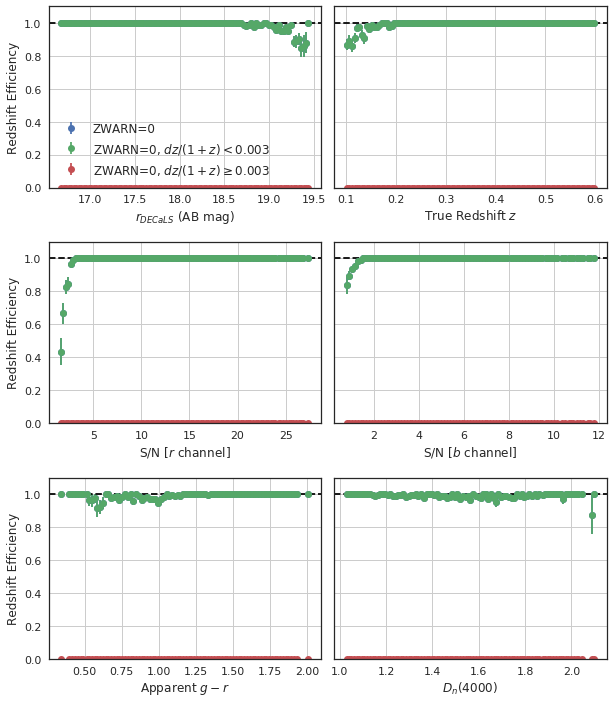

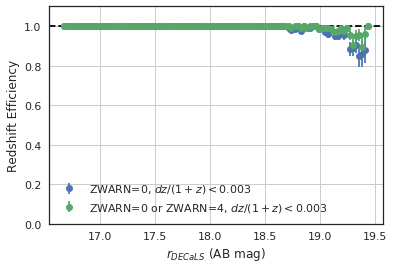

In [29]:
ind += 1
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)

Sim: sim03 with nspec: 1000 and nsim: 10
ObsConds ExpTime: 300-720, MoonFrac: 0.8, MoonAlt: 30, MoonSep: 120


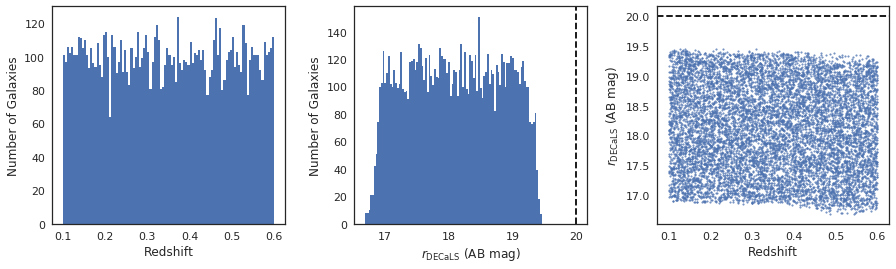

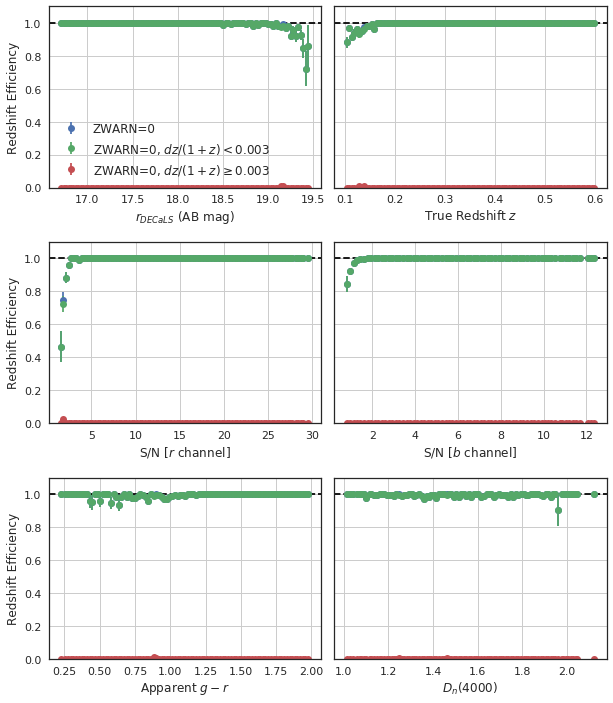

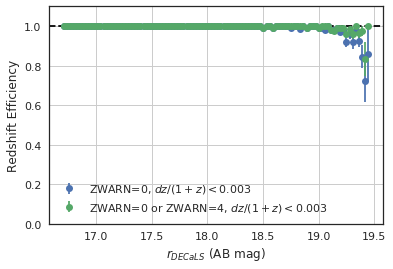

In [30]:
ind += 1
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)

Sim: sim04 with nspec: 1000 and nsim: 10
ObsConds ExpTime: 600, MoonFrac: 0.6-0.98, MoonAlt: 30, MoonSep: 120


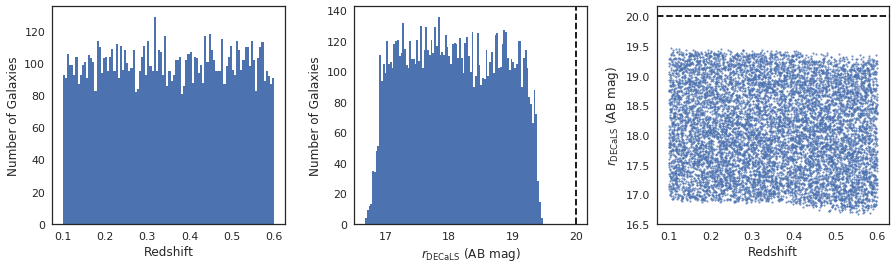

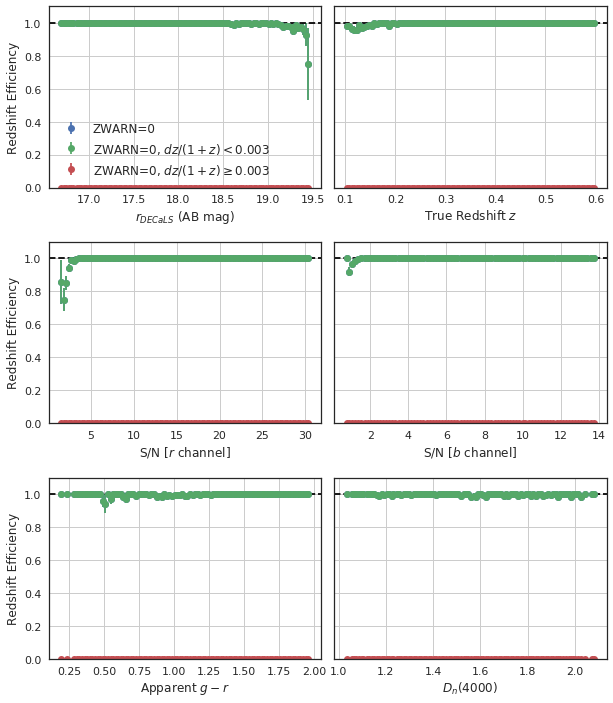

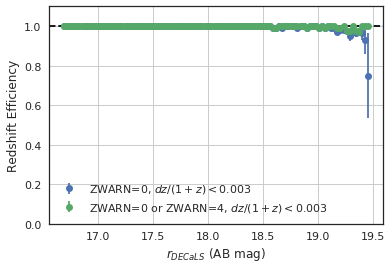

In [31]:
ind += 1
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)

In [32]:
ind += 1
if len(sims)>ind:
    sim,obs = sims[ind],conditions[ind]
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    #log.info('Reading {}'.format(resultfile))
    print('Sim: {} with nspec: {} and nsim: {}'.format(sim['suffix'],sim['nspec'],sim['nsim']))
    if 'EXPTIME' in obs.keys():
        exptime = "{}".format(obs['EXPTIME'])
    else:
        exptime = "{}-{}".format(obs['exptimemin'],obs['exptimemax'])
    if 'MOONFRAC' in obs.keys():
        moonfrac = "{}".format(obs['MOONFRAC'])
    else:
        moonfrac = "{}-{}".format(obs['moonfracmin'],obs['moonfracmax'])
    print('ObsConds ExpTime: {}, MoonFrac: {}, MoonAlt: {}, MoonSep: {}'.format(exptime,moonfrac,obs['MOONALT'],obs['MOONSEP']))
    result = Table.read(resultfile)
    #result.pprint()
    qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)
    qa_efficiency(result)
    qa_zwarn4(result)